##### Option 3: Use Embedding of selfies structure

We will create an embedding of the "SELFIE" tokens using  `tensorflow` [StringLookup](https://www.tensorflow.org/api_docs/python/tf/keras/layers/StringLookup) to encode the selfie tokens into consistent categorical int values, and [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) to create a the embedding vector for each Chromophore.

The `y` dataframe already includes the encoded `selfie` string for each chromophore, but we will need to pad the tokens to a max-length as the Emdedding requires that all the feature vectors be of the same length.

We could use the `selfies` module inbuild functions to split the selfies and create a standard vocab or alphabet of tokens that we will see, but they are a little clunky as they return consumable generator objects.  So using simple regular expression to do the same job.

We can add extra 'buckets' for 'out-of-vocab' tokens that could be present in molecules not in the training set, and we need to add a special 'mask token' `[nop]` to represent a padded token that should be ignored.

In [ ]:
'''
THIS ONLY RUNS IN GOOGLE COLAB
'''

import sys
import os
from google.colab import drive

!pip install rdkit
!pip install selfies

google_drive_dir_path = '/content/drive/MyDrive/Spectrum'
drive.mount('/content/drive')
os.chdir(google_drive_dir_path)
sys.path.append(google_drive_dir_path)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 50.3 MB/s eta 0:00:00
Mounted at /content/drive
mkdir: cannot create directory ‘models’: File exists


In [1]:
import re

import tensorflow as tf
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils import DataSet, plot_results


In [2]:
# Helper functions to tokenize selfies
def split_selfie(selfie):
    """Split a selfie string into a list of tokens."""
    tokens = re.findall(r"(\[.*?\])", selfie)
    return tokens

def pad_selfie(selfie, pad_length):
    """Pad a selfie to a standard length and convert to a tensor."""
    tokens = split_selfie(selfie)
    padding = ["[nop]"] * (pad_length - len(tokens))
    tokens = tokens + padding
    return tf.convert_to_tensor(tokens, dtype=tf.string)


def pad_selfies_tokens(selfies, pad_length):
    """Pad a list of tokens to a standard length and convert to a tensor."""
    selfies_tokens = [pad_selfie(selfie, pad_length) for selfie in selfies]
    return tf.convert_to_tensor(selfies_tokens, dtype=tf.string)

In [3]:
# Load the data
lec_data = DataSet("LogExtCoeff", fill_na="drop")

In [4]:
# Tokenize the SELFIES
selfie_tokens = [split_selfie(s) for s in lec_data.y["SELFIES"]]

# Calculate the maximum length of the SELFIES
max_len = max([len(tokens) for tokens in selfie_tokens])
print(f"Max length: {max_len}")

# Create a vocabulary of all the SELFIES tokens
vocab = list(set([token for tokens in selfie_tokens for token in tokens]))
print(f"Number of token_vocab: {len(vocab)}")

# Create the train and test tokenized SELFIES
y_train = lec_data.y_train["LogExtCoeff"]
y_test = lec_data.y_test["LogExtCoeff"]
sf_train = pad_selfies_tokens(lec_data.y_train["SELFIES"], max_len)
sf_test = pad_selfies_tokens(lec_data.y_test["SELFIES"], max_len)

Max length: 283
Number of token_vocab: 68


2023-07-25 16:59:22.148883: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-07-25 16:59:22.148908: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-07-25 16:59:22.148911: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-07-25 16:59:22.148942: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-25 16:59:22.148957: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
'''
NOT INTENDED TO RUN IF NOT IN GOOGLE COLAB
'''

# Create the lookup and embedding parameters
num_oov = 2

lookup_params = {
    "vocabulary": vocab,
    "mask_token": "[nop]",
    "num_oov_indices": num_oov,
    "name": "SELFIES_LOOKUP",
}

embed_params = {
    "input_dim": len(vocab) + num_oov,
    "output_dim": 256,
    "mask_zero": True,
    "name": "SELFIES_EMBEDDING",
}

# Create the model
model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(max_len,), dtype=object, name="SELFIES"),
        tf.keras.layers.StringLookup(**lookup_params),
        tf.keras.layers.Embedding(**embed_params),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128)),
        tf.keras.layers.Dense(64, activation='relu', name="HIDDEN_0"),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1, name="OUTPUT"),
    ]
)

# Set the model compile parameters
compile_params = {
    "optimizer": "adam",
    "loss": "mean_squared_error",
}

model.compile(**compile_params)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 SELFIES_LOOKUP (StringLook  (None, 283)               0         
 up)                                                             
                                                                 
 SELFIES_EMBEDDING (Embeddi  (None, 283, 256)          17920     
 ng)                                                             
                                                                 
 bidirectional (Bidirection  (None, 256)               296448    
 al)                                                             
                                                                 
 HIDDEN_0 (Dense)            (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                        

In [ ]:
'''
NOT INTENDED TO RUN IF NOT IN GOOGLE COLAB
'''

history = model.fit(
    sf_train,
    y_train,
    validation_split=0.25,
    epochs=10,
    batch_size=64,
)

Epoch 1/10
76/76 [==============================] - 4s 56ms/step - loss: 0.0500 - val_loss: 0.0748
Epoch 2/10
76/76 [==============================] - 3s 34ms/step - loss: 0.0482 - val_loss: 0.0763
Epoch 3/10
76/76 [==============================] - 3s 34ms/step - loss: 0.0466 - val_loss: 0.0806
Epoch 4/10
76/76 [==============================] - 3s 34ms/step - loss: 0.0484 - val_loss: 0.0782
Epoch 5/10
76/76 [==============================] - 3s 46ms/step - loss: 0.0489 - val_loss: 0.0820
Epoch 6/10
76/76 [==============================] - 3s 46ms/step - loss: 0.0482 - val_loss: 0.0760
Epoch 7/10
76/76 [==============================] - 3s 35ms/step - loss: 0.0476 - val_loss: 0.0753
Epoch 8/10
76/76 [==============================] - 3s 35ms/step - loss: 0.0483 - val_loss: 0.0756
Epoch 9/10
76/76 [==============================] - 3s 35ms/step - loss: 0.0453 - val_loss: 0.0768
Epoch 10/10
51/51 [==============================] - 1s 12ms/step
R2 score:  0.767


In [5]:
loaded_model = tf.keras.models.load_model('models/lec_selfie_GRU_model.keras')

In [7]:
model_preds = loaded_model.predict(sf_test)
r2 = r2_score(y_true=y_test, y_pred=model_preds)
print(f"R2 score: {r2: .3f}")

2023-07-25 16:57:42.098824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-25 16:57:42.393174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-25 16:57:42.462336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


51/51 [==============================] - 4s 43ms/step
R2 score: -18.215


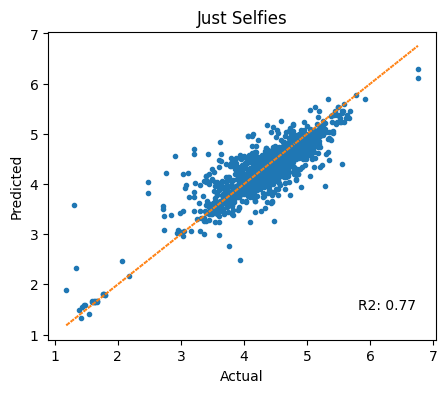

In [ ]:
plot_results(y_test, model_preds, title="Just Selfies", r2_score=r2, save=False)

In [ ]:
df = pd.DataFrame(y_test)
df['Pred'] = model_preds.ravel()
df['Abs_Diff'] = (df['LogExtCoeff'] - df['Pred']).abs()

In [ ]:
df.head()

,LogExtCoeff,Pred,Abs_Diff
17426,4.728477,4.801084,0.072606
917,4.410000,4.550826,0.140826
4842,4.270000,4.118762,0.151238
13070,4.680336,4.665737,0.014598
12709,5.555094,5.461073,0.094022


In [ ]:
df = df.sort_values(by="Abs_Diff", ascending=False)
df.head()

,LogExtCoeff,Pred,Abs_Diff
13052,1.298853,3.581895,2.283042
20031,2.900000,4.560437,1.660437
12162,2.477121,4.038464,1.561342
14175,3.204120,4.699180,1.495060
14116,2.763428,4.227038,1.463610


In [ ]:
# save the model
model.save('models/lec_selfie_GRU_model.keras')